In [1]:
import stravalib
import pandas as pd
import matplotlib.pyplot as plt


In [2]:
import os
from dotenv import load_dotenv
load_dotenv()

True

In [3]:
client = stravalib.Client()

MY_STRAVA_CLIENT_ID = os.getenv("MY_STRAVA_CLIENT_ID")
MY_STRAVA_CLIENT_SECRET = os.getenv("MY_STRAVA_CLIENT_SECRET")
ACCESS_TOKEN = os.getenv('STRAVA_ACCESS_TOKEN')
REFRESH_TOKEN = os.getenv("STRAVA_REFRESH_TOKEN")

client.access_token = ACCESS_TOKEN
client.refresh_token = REFRESH_TOKEN

In [4]:
# refresh_response = client.refresh_access_token(
#     client_id=MY_STRAVA_CLIENT_ID, 
#     client_secret=MY_STRAVA_CLIENT_SECRET, 
#     refresh_token=REFRESH_TOKEN
# )

In [6]:
def fetch_activities(client, activity_type='Run', distance_min=9.5, distance_max=10.5):
    activities = client.get_activities()
    activity_data = []

    for activity in activities:
        if activity.type == activity_type and distance_min <= activity.distance.num / 1000 <= distance_max:
            pace = activity.moving_time.total_seconds() / (activity.distance.num / 1000)
            activity_data.append({
                'athlete': activity.athlete.id,
                'distance': activity.distance.num / 1000,  # Convert meters to kilometers
                'moving_time': activity.moving_time.total_seconds() / 60,  # Convert seconds to minutes
                'pace': pace / 60  # Convert seconds per km to minutes per km
            })

    return pd.DataFrame(activity_data)

In [7]:
df_activities = fetch_activities(client)
df_activities

,athlete,distance,moving_time,pace
0,118593924,10.0059,62.850000,6.281294
1,118593924,10.0090,64.133333,6.407567
2,118593924,10.0057,61.566667,6.153159
3,118593924,10.0413,59.833333,5.958724
4,118593924,10.0046,60.966667,6.093863
5,118593924,10.0096,61.800000,6.174073
6,118593924,10.0205,61.583333,6.145735
7,118593924,10.0052,59.350000,5.931915
8,118593924,10.2743,64.050000,6.234001
9,118593924,10.0397,62.950000,6.270108


In [12]:
df_activities['pace'].describe()

count    12.000000
mean      6.138614
std       0.149873
min       5.921423
25%       6.058314
50%       6.149447
75%       6.243028
max       6.407567
Name: pace, dtype: float64

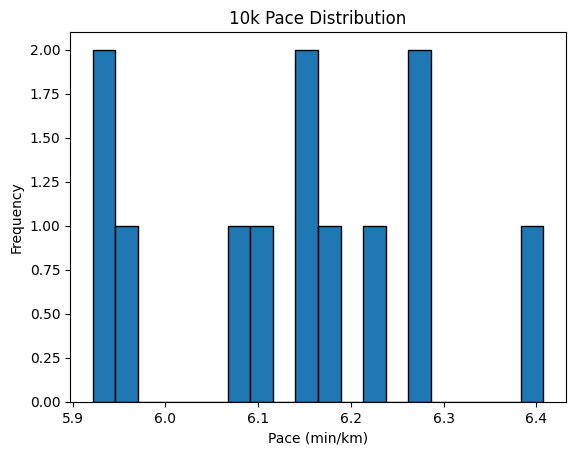

In [13]:
plt.hist(df_activities['pace'], bins=20, edgecolor='black')
plt.title('10k Pace Distribution')
plt.xlabel('Pace (min/km)')
plt.ylabel('Frequency')
plt.show()

In [8]:
activities = client.get_activities(limit=1000)

In [9]:
my_cols =['name',
          'start_date_local',
          'type',
          'distance',
          'moving_time',
          'elapsed_time',
          'total_elevation_gain',
          'elev_high',
          'elev_low',
          'average_speed',
          'max_speed',
          'average_heartrate',
          'max_heartrate',
          'start_latlng']

In [10]:
data = []
for activity in activities:
    my_dict = activity.to_dict()
    data.append([activity.id]+[my_dict.get(x) for x in my_cols])
    
# Add id to the beginning of the columns, used when selecting a specific activity
my_cols.insert(0,'id')

In [11]:
df = pd.DataFrame(data, columns=my_cols)
# Make all walks into hikes for consistency
df['type'] = df['type'].replace('Walk','Hike')
# Create a distance in km column
df['distance_km'] = df['distance']/1e3
# Convert dates to datetime type
df['start_date_local'] = pd.to_datetime(df['start_date_local'])
# Create a day of the week and month of the year columns
df['day_of_week'] = df['start_date_local'].dt.day_name()
df['month_of_year'] = df['start_date_local'].dt.month
# Convert times to timedeltas
df['moving_time'] = pd.to_timedelta(df['moving_time'])
df['elapsed_time'] = pd.to_timedelta(df['elapsed_time'])
# Convert timings to hours for plotting
df['elapsed_time_hr'] = df['elapsed_time'].astype(int)/3600e9
df['moving_time_hr'] = df['moving_time'].astype(int)/3600e9

In [12]:
df

,id,name,start_date_local,type,distance,moving_time,elapsed_time,total_elevation_gain,elev_high,elev_low,average_speed,max_speed,average_heartrate,max_heartrate,start_latlng,distance_km,day_of_week,month_of_year,elapsed_time_hr,moving_time_hr
0,11918053449,Afternoon Run,2024-07-18 14:03:07,Run,1015.1,0 days 00:04:35,0 days 00:04:35,0.0,0.0,0.0,3.691,4.328,143.0,163.0,None,1.0151,Thursday,7,0.076389,0.076389
1,11895324632,Evening Run,2024-07-15 19:02:25,Run,12005.8,0 days 01:15:46,0 days 01:15:46,24.0,14.8,1.4,2.641,4.976,160.4,170.0,"[32.09694603458047, 34.82097337022424]",12.0058,Monday,7,1.262778,1.262778
2,11871605694,Evening Run,2024-07-12 19:22:44,Run,10005.9,0 days 01:02:51,0 days 01:02:51,23.0,14.6,4.2,2.653,5.128,159.5,168.0,"[32.09690102376044, 34.82103313319385]",10.0059,Friday,7,1.047500,1.047500
3,11855557757,Evening Run,2024-07-10 18:43:53,Run,8004.2,0 days 00:52:58,0 days 00:53:01,21.0,16.8,6.6,2.519,4.726,159.0,167.0,"[32.09698325023055, 34.82097337022424]",8.0042,Wednesday,7,0.883611,0.882778
4,11839262871,Evening Run,2024-07-08 19:14:05,Run,10009.0,0 days 01:04:08,0 days 01:04:08,15.0,17.0,7.6,2.601,5.130,158.5,170.0,"[32.0969532430172, 34.82096632942557]",10.0090,Monday,7,1.068889,1.068889
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
87,9152533956,Evening Walk,2023-05-25 19:36:28,Hike,5734.6,0 days 00:47:06,0 days 00:48:36,37.4,37.4,6.0,2.029,2.944,NaN,NaN,"[32.09648888558149, 34.78874151594937]",5.7346,Thursday,5,0.810000,0.785000
88,9152533934,Morning Walk,2023-05-19 10:06:07,Hike,1439.9,0 days 00:05:27,0 days 00:11:39,10.8,24.2,13.2,4.403,2.912,NaN,NaN,"[32.094340939074755, 34.82219788245857]",1.4399,Friday,5,0.194167,0.090833
89,9152534227,Evening Walk,2023-05-08 19:18:46,Hike,6006.1,0 days 00:59:38,0 days 01:03:47,47.8,37.8,5.0,1.679,2.771,NaN,NaN,"[32.09608806297183, 34.78480135090649]",6.0061,Monday,5,1.063056,0.993889
90,9152534288,Evening Walk,2023-05-02 19:28:49,Hike,3454.8,0 days 00:28:06,0 days 00:39:54,21.6,28.6,5.6,2.049,2.825,NaN,NaN,"[32.063125390559435, 34.76153913885355]",3.4548,Tuesday,5,0.665000,0.468333


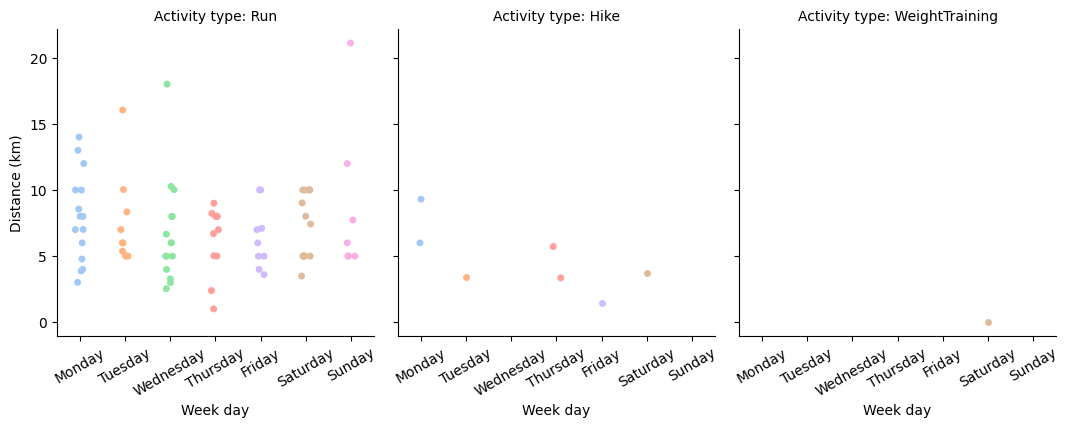

In [13]:
import seaborn as sns

day_of_week_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday' ]
g = sns.catplot(x='day_of_week', y='distance_km', kind='strip', data=df, order=day_of_week_order, col='type', height=4, aspect=0.9, palette='pastel')
(g.set_axis_labels("Week day", "Distance (km)")
  .set_titles("Activity type: {col_name}")
  .set_xticklabels(rotation=30));

In [19]:
activity_number=1
types = ['time', 'distance', 'latlng', 'altitude', 'velocity_smooth', 'moving', 'grade_smooth']
activity_data=client.get_activity_streams(df['id'][activity_number], types=types)